In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import json
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Загружаем датасеты
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_6.Recomendation_Challenge/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_6.Recomendation_Challenge/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_6.Recomendation_Challenge/sample_submission.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# Постройчно прочитаем json с метаданными и положим результат в датасет "meta"
with open('/content/drive/MyDrive/Colab Notebooks/Project_6.Recomendation_Challenge/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)

In [11]:
# Удалим дубликаты из тренировочного датасета
train.drop_duplicates(inplace = True)

# Объединим тренировочный датасет и данные из meta по идентификатору asin (Amazon Standard Identification Number)
df_new_train = pd.merge(train, meta, on='asin')

Рассмотрим тестовый и тренировочный датасеты.

In [12]:
def param_data(data): # посмотрим на данные
    """dataset required parameters """
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              'loc[0]': data.loc[0].values,
              }, 
             index = data.loc[0].index)
    return param

pd.concat([param_data(train), param_data(test)], 
          axis=1, 
          keys = [f'↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ {train.shape}', f'↓ ТЕСТОВАЯ ВЫБОРКА ↓ {test.shape}'],  
          sort=False)

↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ (828935, 14)  ... ↓ ТЕСТОВАЯ ВЫБОРКА ↓ (285965, 11)
                                           dtypes  ...                            loc[0]
overall                                   float64  ...                               NaN
verified                                     bool  ...                              True
reviewTime                                 object  ...                        10 1, 2016
asin                                       object  ...                        B001E5E3X0
reviewerName                               object  ...                         Rudys Mom
reviewText                                 object  ...                               NaN
summary                                    object  ...                               NaN
unixReviewTime                              int64  ...                        1475280000
vote                                       object  ...                               NaN
style                                      object  ...                               NaN
image                                      object  ...                               NaN
userid                                      int64  ...                             68877
itemid                                      int64  ...                              7506
rating                                    float64  ...                               NaN
Id                                            NaN  ...                                 0

[15 rows x 8 columns]

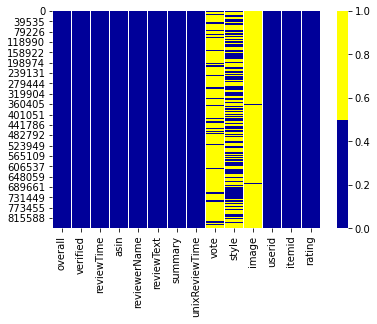

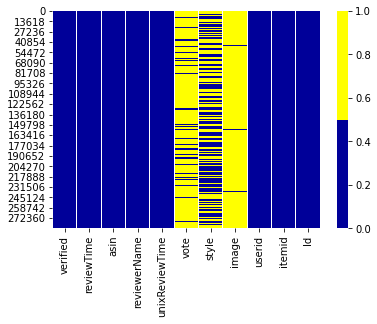

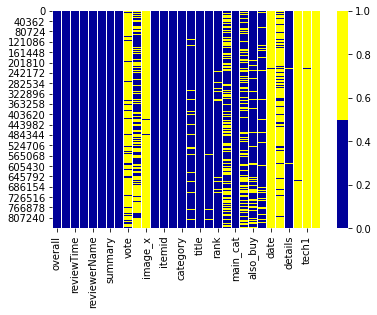

In [13]:
def viz_na(data):
    """NA visualisation"""
    global cols
    cols = data.columns # запишем названия строки сделаем переменную глобальной
    # определяем цвета 
    # желтый - пропущенные данные, синий - не пропущенные
    colours = ['#000099', '#ffff00'] 
    sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))
    plt.show()


viz_na(train)
viz_na(test)
viz_na(df_new_train)

In [14]:
train.info()
test.info()
df_new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 129.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Da

In [15]:
def stat_na_per_percent(data):
    print(f'{data.shape}')
    for col in data.columns:
        pct_missing = np.mean(data[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))
    print("END", end = '\n\n')
stat_na_per_percent(train)
stat_na_per_percent(test)
stat_na_per_percent(df_new_train)

(828935, 14)
overall - 0%
verified - 0%
reviewTime - 0%
asin - 0%
reviewerName - 0%
reviewText - 0%
summary - 0%
unixReviewTime - 0%
vote - 86%
style - 48%
image - 99%
userid - 0%
itemid - 0%
rating - 0%
END

(285965, 11)
verified - 0%
reviewTime - 0%
asin - 0%
reviewerName - 0%
unixReviewTime - 0%
vote - 86%
style - 48%
image - 99%
userid - 0%
itemid - 0%
Id - 0%
END

(847593, 30)
overall - 0%
verified - 0%
reviewTime - 0%
asin - 0%
reviewerName - 0%
reviewText - 0%
summary - 0%
unixReviewTime - 0%
vote - 86%
style - 48%
image_x - 99%
userid - 0%
itemid - 0%
rating - 0%
category - 0%
description - 8%
title - 0%
brand - 1%
rank - 4%
also_view - 45%
main_cat - 0%
price - 31%
also_buy - 14%
image_y - 11%
date - 99%
feature - 83%
details - 2%
similar_item - 100%
tech1 - 99%
fit - 100%
END



Видим, что в тренировочном датасете на три столбца больше:

* присутствует overall - оценка по пятибальной шкале
* присутствует reviewText - текст отзыва
* присутствует summary - краткое содержание отзыва
* присутствует rating - целевая переманная
* отсутствует Id
* Очень высокий процент пропусков в столбцах vote и image

Сделаем копию расширенного датасета, чтобы экспериментировать, не подгружая каждый раз данныее заново, если что то пойдет не так...

In [16]:
df = df_new_train.copy()

In [17]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'vote', 'style', 'image_x',
       'userid', 'itemid', 'rating', 'category', 'description', 'title',
       'brand', 'rank', 'also_view', 'main_cat', 'price', 'also_buy',
       'image_y', 'date', 'feature', 'details', 'similar_item', 'tech1',
       'fit'],
      dtype='object')

14 колонок - в train, 11 - в test, остальные колонки появились получается из метаданных

## EDA

In [18]:
df.head(5)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5.0,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,NaN,117314,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
2,3.0,True,"03 11, 2017",B01CPNIEQG,Ella,"Ummm....interesting spice blend, but not reall...","It's not a bad taste, but they really shouldn'...",1489190400,4,NaN,NaN,119505,37138,0.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
3,5.0,False,"05 18, 2016",B01CPNIEQG,A. Yeager,I have loved adobo seasoning for years. Once I...,I have loved adobo seasoning for years,1463529600,NaN,NaN,NaN,124302,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
4,5.0,False,"05 18, 2016",B01CPNIEQG,LuvstoShop,I love this blend. It makes my hashbrowns! So ...,Five Stars,1463529600,NaN,NaN,NaN,121986,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


df.info()

Всего 30 признаков. 1 бинарный, 5 числовых и 24 категориальных. Пройдемся по признакам.

Напишем функцию, которая выдаст нам необходимую информацию для первичного анализа признака.

In [19]:
# Функция без гистограммы
def col_info(col):
    print('Количество пропусков: {},'.format(col.isnull().sum()))
    print('{},'.format(col.describe()))
    print('Распределение:\n{},'.format(col.value_counts()))

# Функция с гистограммой
def col_info_hist(col):
    print('Количество пропусков: {},'.format(col.isnull().sum()))
    print('{},'.format(col.describe()))
    print('Распределение:\n{},'.format(col.value_counts()))
    col.hist()

Пройдемся по признакам:

### Overall

Количество пропусков: 0,
count    847593.000000
mean          4.441068
std           1.065026
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64,
Распределение:
5.0    607524
4.0    111868
3.0     59795
1.0     37071
2.0     31335
Name: overall, dtype: int64,


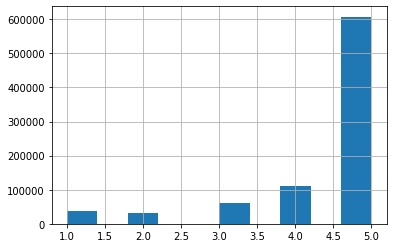

In [20]:
col_info_hist(df.overall)

Похоже на оценку по пятибальной шкале. Подавляющее большинство - пятерки. 
Пропусков нет. Данного признака нет в тестовой выборке, но мы можем использовать его для анализа других признаков.

In [21]:
df['overall']=df['overall'].astype('int32')

### verified

In [22]:
col_info(df.verified)

Количество пропусков: 0,
count     847593
unique         2
top         True
freq      736369
Name: verified, dtype: object,
Распределение:
True     736369
False    111224
Name: verified, dtype: int64,


Данный признак скорее всего означает, что либо комментарий, либо аккаунт пользователя подтвержден. Пропусков нет. Заменим значения на 1 и 0.

In [23]:
dict_verified = {
    True: 1,
    False: 0
}
df['verified'] = df['verified'].map(dict_verified)

Посмотрим, как влияет признак verified на среднюю оценку.

Средняя оценка при значении verified = 1:  4.479455273103566
Средняя оценка при значении verified = 0:  4.186920089189384


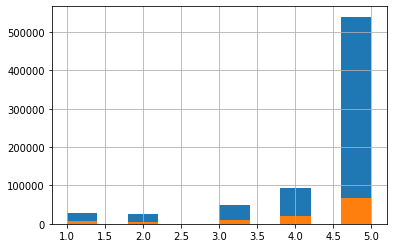

In [24]:
print('Средняя оценка при значении verified = 1: ',df[df.verified == 1].overall.mean())
df['overall'][df['verified'] == 1].hist(bins=10)
print('Средняя оценка при значении verified = 0: ',df[df.verified == 0].overall.mean())
df['overall'][df['verified'] == 0].hist(bins=10)

Видим, что средняя оценка товаров с признаком verified = 1 выше, но в целом распределение оценок похожее.

### reviewTime

In [25]:
col_info(df.reviewTime)

Количество пропусков: 0,
count         847593
unique          4580
top       03 1, 2016
freq             941
Name: reviewTime, dtype: object,
Распределение:
03 1, 2016     941
07 14, 2016    873
01 20, 2016    783
06 3, 2015     783
02 20, 2016    767
              ... 
07 1, 2006       1
04 8, 2006       1
12 3, 2006       1
04 27, 2007      1
01 20, 2006      1
Name: reviewTime, Length: 4580, dtype: int64,


Дата отзыва. Эта информация есть в колонке unixReviewTime в более удобном формате. Удалим данный столбец.

In [26]:
df = df.drop(['reviewTime'], axis=1)

### reviewerName

In [27]:
col_info(df.reviewerName)

Количество пропусков: 168,
count              847425
unique             101207
top       Amazon Customer
freq                31346
Name: reviewerName, dtype: object,
Распределение:
Amazon Customer      31346
Kindle Customer       6128
Linda                  729
John                   714
David                  606
                     ...  
amazons                  1
Mary Cuff                1
shy musa                 1
Gregory P. Smith         1
Queeenmum Johnson        1
Name: reviewerName, Length: 101207, dtype: int64,


Видим, что довольно много отзывов с Амазона и Киндла. 180 пропусков. Проверим, один userid у Amazon Customer, или одному имени пользователя может соответствовать несколько userid.

In [28]:
df[df.reviewerName=='Amazon Customer'].userid.value_counts()

7477      91
1330      60
24035     55
8027      53
15752     44
          ..
73871      1
115807     1
58045      1
62767      1
65437      1
Name: userid, Length: 5329, dtype: int64

В таком случае, имя пользователя нам не нужно. Удалим столбец. UserId информативней.

In [29]:
df = df.drop(['reviewerName'], axis=1)

### reviewText

In [30]:
print('Количество пропусков: {},'.format(df.reviewText.isnull().sum()))

Количество пропусков: 278,


Посмотрим на пример отзыва

In [31]:
df.reviewText[7]

'This is the second time buying this product . A little goes a long way . Love the blend .'

К сожалению, данного столбца нет в тестовой выборке. Поэтому удалим его. Но код ниже сохраню для будущих работ. Он позволяет выделить наиболее часто встречающиеся слова в отзывах и по ним создать dummy-переменные

In [32]:
'''# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить
N_WORDS = 200

# Приведем значения к str
df['reviewText']=df['reviewText'].astype('str')
# Разбиваем reviewText на список слов, предварительно приводим текст к нижнему регистру
df['reviewText']=df['reviewText'].apply(lambda x: re.sub("[^\w]", " ",  x.lower()).split())
                                        
# Создаем пустой список, в который будут добавляться все слова
all_words = []

# Добавляем слова каждой записи в общий список
for words in df.reviewText:
    # разбиваем текст на слова, предварительно приводим к нижнему регистру
    all_words.extend(words)

# Считаем частоту слов в датасете
cnt = Counter()
for word in all_words:
    cnt[word] +=1
    
#Оставим топ N_WORDS слов
top_words = []
for i in range (0, len(cnt.most_common(N_WORDS))):
    words = cnt.most_common(N_WORDS)[i][0]
    top_words.append(words)
    
# Удаляем дубликаты из all_words
all_words = list(dict.fromkeys(all_words))

print('Всего слов ', len(all_words))
print('Топ', N_WORDS, 'слов: ',top_words)'''

'# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить\nN_WORDS = 200\n\n# Приведем значения к str\ndf[\'reviewText\']=df[\'reviewText\'].astype(\'str\')\n# Разбиваем reviewText на список слов, предварительно приводим текст к нижнему регистру\ndf[\'reviewText\']=df[\'reviewText\'].apply(lambda x: re.sub("[^\\w]", " ",  x.lower()).split())\n                                        \n# Создаем пустой список, в который будут добавляться все слова\nall_words = []\n\n# Добавляем слова каждой записи в общий список\nfor words in df.reviewText:\n    # разбиваем текст на слова, предварительно приводим к нижнему регистру\n    all_words.extend(words)\n\n# Считаем частоту слов в датасете\ncnt = Counter()\nfor word in all_words:\n    cnt[word] +=1\n    \n#Оставим топ N_WORDS слов\ntop_words = []\nfor i in range (0, len(cnt.most_common(N_WORDS))):\n    words = cnt.most_common(N_WORDS)[i][0]\n    top_words.append(words)\n    \n# Удаляем дубликаты из all_words\nall_

Отберем из получившихся топ 200 слов 50 наиболее значимых по нашему мнению.

In [33]:
'''
top_word_list = [
    'good',
    'great',
    'like',
    'so',
    'taste',
    'very',
    'flavor',
    'love',
    'tea',
    'product',
    'coffee',
    'more',
    'really',
    'price',
    'much',
    'buy',
    'best',
    'make',
    'time',
    'sugar',
    'little',
    'delicious',
    'only',
    'chocolate',
    'better',
    'again',
    'well',
    'nice',
    'tastes',
    'sweet',
    'fresh',
    'favorite',
    'eat',
    'cup',
    'now',
    'quality',
    'tasty',
    'salt',
    'organic',
    'brand',
    'flavors',
    'oil',
    'perfect',
    'first',
    'order',
    'many',
    'box',
    'mix',
    'always',
    'hot',
] '''

"\ntop_word_list = [\n    'good',\n    'great',\n    'like',\n    'so',\n    'taste',\n    'very',\n    'flavor',\n    'love',\n    'tea',\n    'product',\n    'coffee',\n    'more',\n    'really',\n    'price',\n    'much',\n    'buy',\n    'best',\n    'make',\n    'time',\n    'sugar',\n    'little',\n    'delicious',\n    'only',\n    'chocolate',\n    'better',\n    'again',\n    'well',\n    'nice',\n    'tastes',\n    'sweet',\n    'fresh',\n    'favorite',\n    'eat',\n    'cup',\n    'now',\n    'quality',\n    'tasty',\n    'salt',\n    'organic',\n    'brand',\n    'flavors',\n    'oil',\n    'perfect',\n    'first',\n    'order',\n    'many',\n    'box',\n    'mix',\n    'always',\n    'hot',\n] "

Создаем на их основе dummy-переменные

In [34]:
'''# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит
def leave_top_words(words):
    top_words = []
    for word in words:
        if word in top_word_list:
            top_words.append(word)
    x = top_words
    return x

# Применим функцию к датасету, оставим только слова из top_word_list в столбце reviewText
df['reviewText'] = df['reviewText'].apply(lambda x: leave_top_words(x))


# Создание dummy-переменных на основе слов из top_word_list

# Функция для отображения категорий в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1
for item in top_word_list:
    column_name = 'reviewText_' + item
    df[column_name] = df['reviewText'].apply(find_item)'''

"# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит\ndef leave_top_words(words):\n    top_words = []\n    for word in words:\n        if word in top_word_list:\n            top_words.append(word)\n    x = top_words\n    return x\n\n# Применим функцию к датасету, оставим только слова из top_word_list в столбце reviewText\ndf['reviewText'] = df['reviewText'].apply(lambda x: leave_top_words(x))\n\n\n# Создание dummy-переменных на основе слов из top_word_list\n\n# Функция для отображения категорий в записи\ndef find_item(cell):\n    if item in cell:\n        return 1\n    return 0\n\n# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1\nfor item in top_word_list:\n    column_name = 'reviewText_' + item\n    df[column_name] = df['reviewText'].apply(find_item)"

-> Продолжение EDA

In [35]:
# Удалим столбец reviewText
df = df.drop(['reviewText'], axis=1)

### summary

In [36]:
df.summary[7]

'Love the blend'

In [37]:
!pip install wordcloud

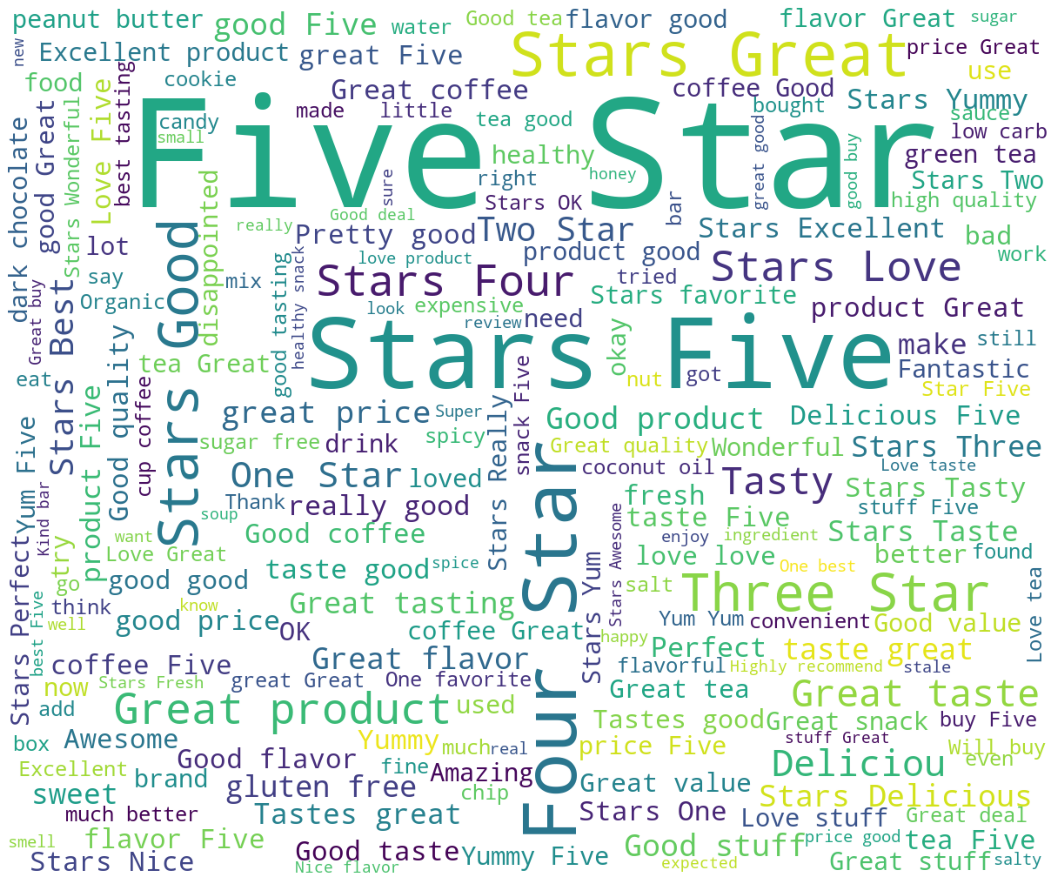

In [38]:
from wordcloud import WordCloud, STOPWORDS

full_text = ' '.join([str(i) for i in df['summary']])

cloud = WordCloud(background_color='white', width=1200, height=1000).generate_from_text(full_text)
plt.figure(figsize=(25,16))
plt.axis('off')
plt.imshow(cloud);

Краткая выдержка из отзыва покупателя, довольно ценный фьюч, однак его нет в тестово датасете. Удалим столбец...

In [39]:
df = df.drop(['summary'], axis=1)

### asin

идентификатор для модели нам не нужен, но у нас есть признаки also_buy и similar_item, для которых он может понадобиться. Пока оставим.

In [40]:
col_info(df.asin)

Количество пропусков: 0,
count         847593
unique         41302
top       B00BUKL666
freq            5430
Name: asin, dtype: object,
Распределение:
B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B0001LO3FG    4252
B00R7PWK7W    2449
              ... 
B0014ENRKG       1
B00DJLKL0Q       1
B00A66UEG8       1
B01A3EDJ6E       1
B00U9W9ML2       1
Name: asin, Length: 41302, dtype: int64,


Видим, что всего у нас 41302 различных продукта.

В дальнейшем мы этот признак не используем т.к. пока не придумали как использовать признаки also_view и also_buy, для которых asin скорее всего понадобится. Пока что удалим.

In [41]:
df = df.drop(['asin'], axis=1)

### unixReviewTime

In [42]:
col_info(df.unixReviewTime)

Количество пропусков: 0,
count    8.475930e+05
mean     1.441914e+09
std      5.992384e+07
min      9.657792e+08
25%      1.412122e+09
50%      1.449360e+09
75%      1.485130e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64,
Распределение:
1456790400    941
1468454400    873
1433289600    783
1453248000    783
1455926400    767
             ... 
1113782400      1
1132444800      1
1167609600      1
1105142400      1
1155081600      1
Name: unixReviewTime, Length: 4580, dtype: int64,


Пропусков нет. Посмотрим, как изменялись оценки со временем.

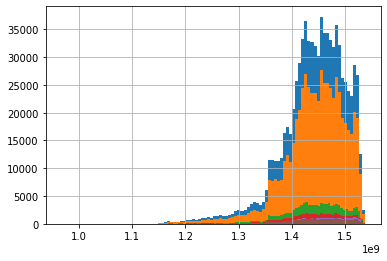

In [43]:
df.unixReviewTime.hist(bins=100)
df[df.overall == 5].unixReviewTime.hist(bins=100)
df[df.overall == 4].unixReviewTime.hist(bins=100)
df[df.overall == 3].unixReviewTime.hist(bins=100)
df[df.overall == 1].unixReviewTime.hist(bins=100)
df[df.overall == 2].unixReviewTime.hist(bins=100)

Посмотрим, на распределение отзывов по датам, приведя даты к удобному виду.

In [44]:
from datetime import datetime
tsmin = df.unixReviewTime.min()
ts25 = int(df.unixReviewTime.quantile(0.25))
ts50 = int(df.unixReviewTime.quantile(0.50))
ts75 = int(df.unixReviewTime.quantile(0.75))
tsmax = df.unixReviewTime.max()
print('Самый первый отзыв:', datetime.utcfromtimestamp(tsmin).strftime('%Y-%m-%d %H:%M:%S'))
print('25 квантиль:', datetime.utcfromtimestamp(ts25).strftime('%Y-%m-%d %H:%M:%S'))
print('50 квантиль:', datetime.utcfromtimestamp(ts50).strftime('%Y-%m-%d %H:%M:%S'))
print('75 квантиль:', datetime.utcfromtimestamp(ts75).strftime('%Y-%m-%d %H:%M:%S'))
print('Последний отзыв:', datetime.utcfromtimestamp(tsmax).strftime('%Y-%m-%d %H:%M:%S'))

Самый первый отзыв: 2000-08-09 00:00:00
25 квантиль: 2014-10-01 00:00:00
50 квантиль: 2015-12-06 00:00:00
75 квантиль: 2017-01-23 00:00:00
Последний отзыв: 2018-10-02 00:00:00


Создадим категории в зависимости от даты написания отзыва

In [45]:
def cat_date(x):
    if x <= ts25: x = 'old'
    elif ts25 < x <= ts50: x = 'middle_old'
    elif ts50 < x <= ts75: x = 'middle_new'
    elif ts75 < x: x = 'new'
    return x      

# Заменим значения в столбце на категории
df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: cat_date(x))

### vote

In [46]:
col_info(df.vote)

Количество пропусков: 728732,
count     118861.0
unique       477.0
top            2.0
freq       30774.0
Name: vote, dtype: float64,
Распределение:
2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
120.0        1
404.0        1
414.0        1
425.0        1
193          1
Name: vote, Length: 477, dtype: int64,


In [47]:
df.vote.unique()

array([nan, 4.0, 5.0, 8.0, '7', 7.0, 3.0, 2.0, '28', '2', '4', 6.0, '3',
       '30', '14', '8', '6', '17', '5', '142', '21', '16', 9.0, 15.0,
       12.0, 18.0, 404.0, 22.0, 10.0, '22', 13.0, 136.0, '18', '12', '34',
       '69', '10', '48', '20', 11.0, 14.0, 133.0, 16.0, 36.0, 31.0, 117.0,
       17.0, 29.0, 37.0, '39', '9', '11', '27', 172.0, 251.0, '41', 52.0,
       38.0, 27.0, '15', '61', '38', 25.0, 127.0, '36', 28.0, 61.0, 24.0,
       49.0, 51.0, 19.0, 20.0, '13', 74.0, 121.0, 45.0, 33.0, 266.0, '44',
       '232', '25', 47.0, 138.0, 176.0, 75.0, 30.0, '42', 128.0, '24',
       '184', '624', 40.0, 272.0, 881.0, 53.0, 21.0, 43.0, 184.0, '35',
       35.0, 23.0, 39.0, 227.0, 42.0, 507.0, 59.0, 114.0, 87.0, 55.0,
       26.0, '19', 41.0, '82', 143.0, 73.0, 187.0, 66.0, '45', 56.0, '76',
       112.0, 57.0, '115', '75', '33', '50', 50.0, 68.0, 54.0, 63.0, '47',
       '43', 108.0, 185.0, '302', 208.0, '59', 269.0, 78.0, 103.0, '26',
       148.0, 160.0, '80', 32.0, 71.0, 130.0, 85

Скорее всего, данные признак показывает количество голосов, отданных за отзыв. Видим, что в значениях числа через запятую, с нулём и без нуля. Также видим большое количество пропусков. Скорее всего, за эти отзывы никто не проголосовал, что вполне естественно, и мы можем заменить пропуски на 0.

In [48]:
# Заменим пропуски на 0
df.vote = df.vote.fillna(0)

In [49]:
# Удалим запятые
df['vote'] = df['vote'].astype('str')
df['vote'] = df['vote'].apply(lambda x: x.replace(',', ''))
# Заменим пропуски на 0
df['vote'] = df['vote'].apply(lambda x: x.replace('nan', '0'))
df.vote = df.vote.fillna(0)
# Приведем к int32
df['vote'] = df['vote'].astype('float')
df['vote'] = df['vote'].astype('int32')
# Посмотрим на результат
df.vote.unique()

array([   0,    4,    5,    8,    7,    3,    2,   28,    6,   30,   14,
         17,  142,   21,   16,    9,   15,   12,   18,  404,   22,   10,
         13,  136,   34,   69,   48,   20,   11,  133,   36,   31,  117,
         29,   37,   39,   27,  172,  251,   41,   52,   38,   61,   25,
        127,   24,   49,   51,   19,   74,  121,   45,   33,  266,   44,
        232,   47,  138,  176,   75,   42,  128,  184,  624,   40,  272,
        881,   53,   43,   35,   23,  227,  507,   59,  114,   87,   55,
         26,   82,  143,   73,  187,   66,   56,   76,  112,   57,  115,
         50,   68,   54,   63,  108,  185,  302,  208,  269,   78,  103,
        148,  160,   80,   32,   71,  130,   85,  123,   62,   95,  603,
         88,   86,  132,   67,  119,   70,  296,  560,   91,   46,  203,
        360,  857,  107,  679,  146,   89,   60,   94,   77,  129,  122,
        223,  100,   65,  101,   64,  255,  116,  171,  276,  186,  190,
        531,  166, 1157,  435,  516,  416,  173,   

Сделаем признак категориальным. Выделим 3 категории по количеству голосов.

In [50]:
# Создадим 3 категории по количеству голосов
def cat_vote(x):
    if x < 10: x = 'low'
    elif 10 <= x <= 100: x = 'middle'
    elif 100 < x: x = 'high'
    return x      

# Заменим значения в столбце на категории
df['vote'] = df['vote'].apply(lambda x: cat_vote(x))

### style

In [51]:
col_info(df['style'])

Количество пропусков: 407242,
count                      440351
unique                      25892
top       {'Size:': ' Pack of 1'}
freq                         4856
Name: style, dtype: object,
Распределение:
{'Size:': ' Pack of 1'}                                                 4856
{'Package Quantity:': ' 1'}                                             4526
{'Package Type:': ' Standard Packaging'}                                3898
{'Size:': ' 1 Pack'}                                                    3848
{'Size:': ' 24 Count'}                                                  3640
                                                                        ... 
{'Size:': ' 3 Ounce (Pack of 6)', 'Flavor:': ' Blackberry Fusion'}         1
{'Size:': ' 10-Ounce Packages (Pack of 12)', 'Flavor:': ' Original'}       1
{'Size:': ' 18 Ounce (Pack of 12)', 'Flavor:': ' Hickory'}                 1
{'Size:': ' ROYAL DECAF Water Process Decaf'}                              1
{'Flavor:': ' MILK CH

Видим словарь из размера упаковки и вкуса. Скорее всего, отсюда можно что-то полезное выделить, но но пропусков больше половины. Займемся если останется время и появятся идеи как это использовать.

In [52]:
df = df.drop(['style'], axis=1)

### image_x

Ссылки на картинки. Удалим столбец.

In [53]:
df = df.drop(['image_x'], axis=1)

### userid

In [54]:
col_info(df.userid)

Количество пропусков: 0,
count    847593.000000
mean      53756.091163
std       37211.809152
min           0.000000
25%       20347.000000
50%       48581.000000
75%       84723.000000
max      127495.000000
Name: userid, dtype: float64,
Распределение:
842      427
17987    317
355      302
2024     296
2809     279
        ... 
66068      1
71046      1
90602      1
37414      1
77032      1
Name: userid, Length: 127448, dtype: int64,


ID пользователя. Пропусков нет, идем дальше.

### itemid

In [55]:
col_info(df.itemid)

Количество пропусков: 0,
count    847593.00000
mean      17090.10489
std       11584.74670
min           0.00000
25%        6478.00000
50%       16108.00000
75%       26719.00000
max       41319.00000
Name: itemid, dtype: float64,
Распределение:
22208    5430
23540    4733
24556    4611
379      4252
32046    2449
         ... 
38965       1
23635       1
34272       1
39917       1
38902       1
Name: itemid, Length: 41302, dtype: int64,


Проверим, если в тестовом и тренировочном датасетах пропущенные id. Это может быть проблемой при предсказании с помощьюу LightFM c item_features.

In [56]:
print('Количество уникальных itemid в тренировочном датасете:',len(df.itemid.unique()))
print('Максимальный itemid в тренировочном датасете:',df.itemid.max()+1)

Количество уникальных itemid в тренировочном датасете: 41302
Максимальный itemid в тренировочном датасете: 41320


Есть пропущенные значения, но не ясно как это повлияет в дальнейшем

In [57]:
df.head(1)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5,1,middle_new,low,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


### rating

In [58]:
col_info(df.rating)

Количество пропусков: 0,
count    847593.000000
mean          0.848747
std           0.358296
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64,
Распределение:
1.0    719392
0.0    128201
Name: rating, dtype: int64,


Целевая переменная. Здесь всего 2 значения - понравился пользователю товар или нет. Посмотрим, как этот признак зависит от оценки.

In [59]:
print('Оценки при rating = 0:\n', df[df.rating == 0].overall.value_counts())
print('Оценки при rating = 1:\n', df[df.rating == 1].overall.value_counts())

Оценки при rating = 0:
 3    59795
1    37071
2    31335
Name: overall, dtype: int64
Оценки при rating = 1:
 5    607524
4    111868
Name: overall, dtype: int64


При оценках 4 или 5 считаем, что товар понравился. 1,2 или 3 - не понравился.

### category

In [60]:
df.category[7]

['Grocery & Gourmet Food',
 'Herbs, Spices & Seasonings',
 'Mixed Spices & Seasonings',
 'Adobo Seasoning']

Видим в данном признаке список категорий, к которй относится товар. Посмотрим, сколько всего категорий и выделим самые популярные.

In [61]:
'''# Зададим переменной количество категорий
N_CATS = 500

# Создаем пустой список, в который будут добавляться все категории
all_categories = []

# Добавляем категории каждой записи в общий список
for category in df.category:
    all_categories.extend(category)

# Считаем частоту категорий в датасете
cnt = Counter()
for word in all_categories:
    cnt[word] +=1
    
#Оставим топ N_CATS категорий
top_cat = []
for i in range (0, len(cnt.most_common(N_CATS))):
    cat = cnt.most_common(N_CATS)[i][0]
    top_cat.append(cat)
    
# Удаляем дубликаты из all_categories
all_categories = list(dict.fromkeys(all_categories))

print('Всего категорий: ', len(all_categories))
print('Топ', N_CATS, 'категорий: ',top_cat)'''

"# Зададим переменной количество категорий\nN_CATS = 500\n\n# Создаем пустой список, в который будут добавляться все категории\nall_categories = []\n\n# Добавляем категории каждой записи в общий список\nfor category in df.category:\n    all_categories.extend(category)\n\n# Считаем частоту категорий в датасете\ncnt = Counter()\nfor word in all_categories:\n    cnt[word] +=1\n    \n#Оставим топ N_CATS категорий\ntop_cat = []\nfor i in range (0, len(cnt.most_common(N_CATS))):\n    cat = cnt.most_common(N_CATS)[i][0]\n    top_cat.append(cat)\n    \n# Удаляем дубликаты из all_categories\nall_categories = list(dict.fromkeys(all_categories))\n\nprint('Всего категорий: ', len(all_categories))\nprint('Топ', N_CATS, 'категорий: ',top_cat)"

Далее мы можем оставить только самые популярные категории и создать на их основе dummy-переменные.

Я пока что закомментировал создание dummy-переменных для топовых категорий. Если хотите с ними обучить модель, то код ниже рабочий

In [62]:
'''# Напишем функцию, которая будет оставлять только топовые категории в списке, остальные удалит
def top_category(categories):
    top_categories = []
    for category in categories:
        if category in top_cat:
            top_categories.append(category)
    x = top_categories
    return x

# Применим функцию к датасету, оставим только топовые категории в стольце category
df['category'] = df['category'].apply(lambda x: top_category(x))


# Создание dummy-переменных на основе топовых категорий 

# Функция для отображения категорий в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы с категориями и заполняем 0 или 1
for item in top_cat:
    column_name = 'category' + item
    df[column_name] = df['category'].apply(find_item)'''

"# Напишем функцию, которая будет оставлять только топовые категории в списке, остальные удалит\ndef top_category(categories):\n    top_categories = []\n    for category in categories:\n        if category in top_cat:\n            top_categories.append(category)\n    x = top_categories\n    return x\n\n# Применим функцию к датасету, оставим только топовые категории в стольце category\ndf['category'] = df['category'].apply(lambda x: top_category(x))\n\n\n# Создание dummy-переменных на основе топовых категорий \n\n# Функция для отображения категорий в записи\ndef find_item(cell):\n    if item in cell:\n        return 1\n    return 0\n\n# Cоздаем столбцы с категориями и заполняем 0 или 1\nfor item in top_cat:\n    column_name = 'category' + item\n    df[column_name] = df['category'].apply(find_item)"

In [63]:
# Удалим столбец с категориями
df = df.drop(['category'], axis = 1)

### description

In [64]:
df.description[7]

['Adobo seasoning (known as adobo seco) is a very popular spice blend used throughout Latin American cooking, though its a fundamental ingredient of Puerto Rican cooking. Primal palate adobo seasoning includes mineral-rich Himalayan pink salt. The result is a beautifully balanced version of the popular blend that is suitable for seasoning any dish. Find recipes using our adobo seasoning www.Primalpalate.Comcertified USDA-organic, whole30 approved, certified gluten-free, kosher, non-GMO, and non-irradiated. Ingredients: Pink Himalayan salt, garlic, onion, black pepper, oregano, turmeric (organic) this item is packaged in a glass bottle with a plastic flip-top shaker cap. It is independently certified gluten-free, and bottled in a nut-free facility.',
 'Ingredients: Pink Himalayan Salt, Garlic*, Onion*, Black Pepper*, Oregano*, Turmeric* (*Organic)',
 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any

Cделаем то же самое, что мы делали для признака reviewText: найдем самые часто встречающиеся слова, оставим только их и подготовимся к созданию dummy-переменных.

In [65]:
'''# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить
N_WORDS = 200

# Сейчас в поле description список строк. Приведем к единой строке.
df['description']=df['description'].astype('str')

# Разбиваем description на список слов, предварительно приводим текст к нижнему регистру
df['description']=df['description'].apply(lambda x: re.sub("[^\w]", " ",  x.lower()).split())
                                        
# Создаем пустой список, в который будут добавляться все слова
all_words = []

# Добавляем слова каждой записи в общий список
for words in df['description']:
    # разбиваем текст на слова, предварительно приводим к нижнему регистру
    all_words.extend(words)

# Считаем частоту слов в датасете
cnt = Counter()
for word in all_words:
    cnt[word] +=1
    
#Оставим топ N_WORDS слов
top_words = []
for i in range (0, len(cnt.most_common(N_WORDS))):
    words = cnt.most_common(N_WORDS)[i][0]
    top_words.append(words)
    
# Удаляем дубликаты из all_words
all_words = list(dict.fromkeys(all_words))

print('Всего слов ', len(all_words))
print('Топ', N_WORDS, 'слов: ',top_words)'''

'# Зададим переменной количество наиболее частов встречающихся слов, которое хотим оставить\nN_WORDS = 200\n\n# Сейчас в поле description список строк. Приведем к единой строке.\ndf[\'description\']=df[\'description\'].astype(\'str\')\n\n# Разбиваем description на список слов, предварительно приводим текст к нижнему регистру\ndf[\'description\']=df[\'description\'].apply(lambda x: re.sub("[^\\w]", " ",  x.lower()).split())\n                                        \n# Создаем пустой список, в который будут добавляться все слова\nall_words = []\n\n# Добавляем слова каждой записи в общий список\nfor words in df[\'description\']:\n    # разбиваем текст на слова, предварительно приводим к нижнему регистру\n    all_words.extend(words)\n\n# Считаем частоту слов в датасете\ncnt = Counter()\nfor word in all_words:\n    cnt[word] +=1\n    \n#Оставим топ N_WORDS слов\ntop_words = []\nfor i in range (0, len(cnt.most_common(N_WORDS))):\n    words = cnt.most_common(N_WORDS)[i][0]\n    top_words.appe

Среди самых частых слов много предлогов и артиклей. Отберем вручную список из 50 значимых по нашему мнению слов.

In [66]:
top_word_list = [
    'health',
    'treat',
    'intended',
    'disease',
    'prevent',
    'cure',
    'dietary',
    'diagnose',
    'evaluated',
    'statements',
    'condition',
    'supplements',
    'fda',
    'organic',
    'flavor',
    'tea',
    'natural',
    'sugar',
    'salt',
    'water',
    'oil',
    'coffee',
    'ingredients',
    'milk',
    'free',
    'products',
    'chocolate',
    'taste',
    'cup',
    'delicious',
    'quality',
    'flavors',
    'soy',
    'food',
    'flour',
    'acid',
    'wheat', 
    'great',
    'powder',
    'corn',
    'nuts',
    'rice',
    'protein',
    'coconut',
    'gluten',
    'butter',
    'syrup',
    'blend',
    'high',
    'best'
]

Далее мы можем оставить только самые популярные слова и создать на их основе dummy-переменные.

Я пока что закомментировал создание dummy-переменных для самых частых слов. Если хотите с ними обучить модель, то код ниже рабочий

In [67]:
'''# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит
def leave_top_words(words):
    top_words = []
    for word in words:
        if word in top_word_list:
            top_words.append(word)
    x = top_words
    return x

# Применим функцию к датасету, оставим только слова из top_word_list в столбце description
df['description'] = df['description'].apply(lambda x: leave_top_words(x))


# Создание dummy-переменных на основе слов из top_word_list

# Функция для отображения категорий в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1
for item in top_word_list:
    column_name = 'description' + item
    df[column_name] = df['description'].apply(find_item)'''

"# Напишем функцию, которая будет оставлять в списке только слова из top_word_list, остальные удалит\ndef leave_top_words(words):\n    top_words = []\n    for word in words:\n        if word in top_word_list:\n            top_words.append(word)\n    x = top_words\n    return x\n\n# Применим функцию к датасету, оставим только слова из top_word_list в столбце description\ndf['description'] = df['description'].apply(lambda x: leave_top_words(x))\n\n\n# Создание dummy-переменных на основе слов из top_word_list\n\n# Функция для отображения категорий в записи\ndef find_item(cell):\n    if item in cell:\n        return 1\n    return 0\n\n# Cоздаем столбцы со словами из top_word_list и заполняем 0 или 1\nfor item in top_word_list:\n    column_name = 'description' + item\n    df[column_name] = df['description'].apply(find_item)"

In [68]:
df = df.drop(['description'], axis = 1)

### title

In [69]:
df.title[7]

'Primal Palate Organic Spices Adobo Seasoning, Certified Organic, 2.6 oz Bottle'

Видим, что title частично содержится в description

In [70]:
df = df.drop(['title'], axis = 1)

### brand

In [71]:
col_info(df.brand)

Количество пропусков: 6104,
count     841489
unique      8866
top         KIND
freq       22506
Name: brand, dtype: object,
Распределение:
KIND                       22506
Bob's Red Mill             13061
Twinings                   11182
Planters                   10384
Frontier                    6926
                           ...  
cocomama                       1
Drumstick                      1
Global Healing Center          1
Mallo Cup                      1
Peanut Butter Americano        1
Name: brand, Length: 8866, dtype: int64,


Пропусков относительно не много. 8866 разных производителей. Можно выделить самых известных и сделать для них dummy-переменные, как мы делали для других категориальных признаков.

In [72]:
'''# Зададим переменной количество производителей
N_BRANDS = 50

# Приведем к str
df['brand']=df['brand'].astype('str')

# Создаем пустой список, в который будут добавляться все производители
all_brands = []

# Добавляем производителя из каждой записи в общий список
for brand in df.brand:
    all_brands.append(brand)

# Считаем количество производителей в датасете
cnt = Counter()
for word in all_brands:
    cnt[word] +=1
    
#Оставим топ N_BRANDS производителей
top_brand = []
for i in range (0, len(cnt.most_common(N_BRANDS))):
    br = cnt.most_common(N_BRANDS)[i][0]
    top_brand.append(br)
    
# Удаляем дубликаты из all_brands
all_brands = list(dict.fromkeys(all_brands))

print('Всего производителей: ', len(all_brands))
print('Топ', N_BRANDS, 'производителей: ',top_brand)'''

"# Зададим переменной количество производителей\nN_BRANDS = 50\n\n# Приведем к str\ndf['brand']=df['brand'].astype('str')\n\n# Создаем пустой список, в который будут добавляться все производители\nall_brands = []\n\n# Добавляем производителя из каждой записи в общий список\nfor brand in df.brand:\n    all_brands.append(brand)\n\n# Считаем количество производителей в датасете\ncnt = Counter()\nfor word in all_brands:\n    cnt[word] +=1\n    \n#Оставим топ N_BRANDS производителей\ntop_brand = []\nfor i in range (0, len(cnt.most_common(N_BRANDS))):\n    br = cnt.most_common(N_BRANDS)[i][0]\n    top_brand.append(br)\n    \n# Удаляем дубликаты из all_brands\nall_brands = list(dict.fromkeys(all_brands))\n\nprint('Всего производителей: ', len(all_brands))\nprint('Топ', N_BRANDS, 'производителей: ',top_brand)"

Далее мы можем оставить только самых популярных производителей и создать на их основе dummy-переменные.

Я пока что закомментировал создание dummy-переменных для топовых категорий. Если хотите с ними обучить модель, то код ниже рабочий

In [73]:
'''# Напишем функцию, которая будет оставлять только топовых производителей, остальных удалит
def leave_top_brand(brands):
    top_brands = []
    for brand in brands:
        if brand in top_brand:
            top_brands.append(brand)
    x = top_brands
    return x

# Применим функцию к датасету, оставим только топовых производителей в стольце brand
df['brand'] = df['brand'].apply(lambda x: leave_top_brand(x))


# Создание dummy-переменных на основе топовых производителей 

# Функция для отображения производителей в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0

# Cоздаем столбцы с производителями и заполняем 0 или 1
for item in top_brand:
    column_name = 'brand_' + item
    df[column_name] = df['brand'].apply(find_item)'''

"# Напишем функцию, которая будет оставлять только топовых производителей, остальных удалит\ndef leave_top_brand(brands):\n    top_brands = []\n    for brand in brands:\n        if brand in top_brand:\n            top_brands.append(brand)\n    x = top_brands\n    return x\n\n# Применим функцию к датасету, оставим только топовых производителей в стольце brand\ndf['brand'] = df['brand'].apply(lambda x: leave_top_brand(x))\n\n\n# Создание dummy-переменных на основе топовых производителей \n\n# Функция для отображения производителей в записи\ndef find_item(cell):\n    if item in cell:\n        return 1\n    return 0\n\n# Cоздаем столбцы с производителями и заполняем 0 или 1\nfor item in top_brand:\n    column_name = 'brand_' + item\n    df[column_name] = df['brand'].apply(find_item)"

In [74]:
df = df.drop(['brand'], axis = 1)

### rank

In [75]:
print('Количество пропусков: {},'.format(df['rank'].isnull().sum()))

Количество пропусков: 34598,


Посмотрим, как выглядят значения

In [76]:
df['rank'][1]

'19,771inGroceryGourmetFood('

Приведем значения данного признака к единому числовому виду

In [77]:
# Приведем все к str
df['rank'] = df['rank'].astype('str')
# Удалим все значения кроме числовых
df['rank'] = df['rank'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на высокий ранг (предположим, что чем ниже ранг, тем лучше)
df['rank'] = df['rank'].apply(lambda x: 9999999 if x == '' else x)
df['rank'] = df['rank'].astype('float')
# Остаются какие-то большие значения, заменим их на высокий ранг
df['rank'] = df['rank'].apply(lambda x: 9999999 if x > 9999999 else x)
df['rank'] = df['rank'].astype('int32')
# Посмотрим на результат
col_info(df['rank'])

Количество пропусков: 0,
count    8.475930e+05
mean     6.676660e+05
std      2.289290e+06
min      4.000000e+00
25%      1.094000e+04
50%      4.999900e+04
75%      1.799160e+05
max      9.999999e+06
Name: rank, dtype: float64,
Распределение:
9999999    47163
18          7421
4575        4733
2949        4611
142261      4252
           ...  
1169810        1
784450         1
293005         1
265756         1
643797         1
Name: rank, Length: 35977, dtype: int64,


Заменим значения на категории. Создание dummy-переменных сделаем после EDA

In [78]:
# Создадим 3 категории рангов
def cat_rank(x):
    if x < 1093: x = 'high'
    elif 1093 <= x <= 18000: x = 'middle'
    elif 18000 < x: x = 'low'
    return x      

# Заменим значения в столбце на категории
df['rank'] = df['rank'].apply(lambda x: cat_rank(x))

### also_view

In [79]:
df.also_view[7]

['B00AJRKRJS',
 'B01NALHAY9',
 'B01DGZ2B48',
 'B01EZ489AO',
 'B01KIIPSOG',
 'B075XT4M1G',
 'B075Y1KVHM',
 'B01LYST8SC',
 'B075XZ4MY3',
 'B001KWF2O6',
 'B01LXTON7K',
 'B07DFS9SSF',
 'B07DFSWXS9',
 'B01DH795LM',
 'B01DPS5VKW',
 'B01EYW2LCE',
 'B00032CVSE',
 'B07DHRRLHL',
 'B075Y1WJH6',
 'B00WKF7X4O',
 'B01IFOCMZS',
 'B00J83KCA8',
 'B01MD0T6G0',
 'B01KIK4J0I',
 'B01KIK7EYG',
 'B001TA9MDQ',
 'B01NBWNGFO',
 'B01F4IDZ6S',
 'B0005YX1BG',
 'B01NAHBW9H',
 'B00061DFEQ',
 'B07GC32M71',
 'B01DPSC5PG',
 'B01K57JCRY',
 'B00WVOD5QY',
 'B0014CVT6C',
 'B0002HAAOW',
 'B00A48YIFQ',
 'B071NLVF3B',
 'B07DM356FK',
 'B000WR4SJ0',
 'B00F8Z4Z3K',
 'B004E5KH28',
 'B07CMDRYRW',
 'B000QJSACU',
 'B000WS1DT2',
 'B07DGGRSY3',
 'B07DL1BRHY',
 'B0097UW3EK',
 'B005SIFI6K',
 'B00W4QQQXS',
 'B01I3V0DFO',
 'B01MTC2PQ7',
 'B002N3XZ6I']

Видим список других товаров в виде asin.

In [80]:
df = df.drop(['also_view'], axis = 1)

### main_cat

In [81]:
col_info(df.main_cat)

Количество пропусков: 955,
count      846638
unique         17
top       Grocery
freq       802613
Name: main_cat, dtype: object,
Распределение:
Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Musical Instruments               3
Software                          3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64,


Избавимся от пропусков. dummy-переменные для категорий создадим после EDA.

In [82]:
# Заменим пропуски на категорию "Other"
df.main_cat = df.main_cat.fillna('Other')

### price

In [83]:
col_info(df.price)

Количество пропусков: 258621,
count     588972
unique      4601
top       $14.99
freq       14241
Name: price, dtype: object,
Распределение:
$14.99              14241
$13.67              10660
$19.99               9043
$14.79               5632
$15.53               5561
                    ...  
$35.52                  2
$6.93                   1
$44.14                  1
$19.99 - $295.00        1
$35.16                  1
Name: price, Length: 4601, dtype: int64,


У нас довольно много пропусков и есть диапозоны цен, например 19.99-295.00. Заменим такие значения и пропуски на среднее значение. Чтобы найти среднее значение, создадим вспомогательный датасет, удалим в нем пропуски в столбце price и посчитаем среднее.

In [84]:
# Скопируем датасет
df_price = df.copy()
# Избавимся от пропусков
df_price = df_price[df_price.price.isna() == False]
df_price = df_price[df_price.price != '']
# Приведем все к str
df_price['price'] = df_price['price'].astype('str')
# Удалим все значения кроме числовых
df_price['price'] = df_price['price'].apply(lambda x: re.sub('\D', '', x))
# Переведем во float
df_price['price'] = df_price['price'].astype('float')
# Удалим все, что дороже 9999$ т.к. это, скорее всего, ошибка
df_price = df_price[df_price.price < 999999]
# Посмотрим на результат
col_info(df_price.price)

Количество пропусков: 0,
count    585001.000000
mean       2069.952270
std        1754.135664
min           1.000000
25%        1155.000000
50%        1691.000000
75%        2599.000000
max       99900.000000
Name: price, dtype: float64,
Распределение:
1499.0    14241
1367.0    10660
1999.0     9043
1479.0     5632
1553.0     5561
          ...  
2504.0        2
2848.0        2
693.0         1
4414.0        1
3516.0        1
Name: price, Length: 4527, dtype: int64,


На вид все ОК. Теперь мы можем сделать похожую процедуру для основного датасета, заменив нулевые значения и диапазоны цен на среднюю цену.

In [85]:
# Чтобы каждый раз не считать среднее значение, используем переменную
df_price_mean = df_price.price.mean()
# Приведем все к str
df['price'] = df['price'].astype('str')
# Удалим все значения кроме числовых
df['price'] = df['price'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на среднее значение
df['price'] = df['price'].apply(lambda x: round(df_price_mean, 0) if x == '' else x)
# Приведем к float
df['price'] = df['price'].astype('float')
# Заменим большие значения на средние
df['price'] = df['price'].apply(lambda x: round(df_price_mean, 0) if x > 999999 else x)
# Приведем к int32
df['price'] = df['price'].astype('int32')
# Смотрим на результат
col_info(df.price)

Количество пропусков: 0,
count    847593.000000
mean       2069.967057
std        1457.295712
min           1.000000
25%        1398.000000
50%        2070.000000
75%        2112.000000
max       99900.000000
Name: price, dtype: float64,
Распределение:
2070    262805
1499     14241
1367     10660
1999      9043
1479      5632
         ...  
3552         2
4906         2
693          1
3516         1
4414         1
Name: price, Length: 4527, dtype: int64,


Поделим цены на 3 категории и создадим dummy-переменные

In [86]:
def cat_price(x):
    if x < 1397: x = 'low'
    elif 1397 <= x <= 2099: x = 'middle'
    elif 2099 < x: x = 'high'
    return x      

df['price'] = df['price'].apply(lambda x: cat_price(x))

### also_buy

In [87]:
print(df.also_buy[7])

['B01DGZ2B48', 'B01EZ489AO', 'B01DH795LM', 'B01EYW2LCE', 'B01IFOCMZS', 'B075XZ4MY3', 'B075Y1KVHM', 'B07DHRRLHL', 'B01DPS5VKW', 'B01LYST8SC', 'B01KIIPSOG', 'B075Y1WJH6', 'B01LXTON7K', 'B07DGGRSY3', 'B07DKGN9FL', 'B01KIK16OA', 'B07GC32M71', 'B01DPSC5PG', 'B01MTC2PQ7', '162860347X', '1328915093', 'B01KIK7EYG', 'B01N5SCAX3', 'B00AJRKRJS', 'B071WY281Q', 'B00VXQGY64', 'B00K6JUG4K', '1607749440', 'B00ZAD36ZS', 'B01K57JCRY', 'B01DQ6Q3D2', 'B01ENL3Q02', '132853104X', 'B07DL1BRHY', 'B07G4FRC1B', 'B07G4CRGFY', 'B001KWF2O6', 'B078XPFWL6', 'B00VXQGY1Y', '1328557472', 'B07DXZT7QH', '1628602945', 'B01NGWIE9Z', 'B00R4XBGJK', 'B019QR8MQQ', 'B01GIW8STI', 'B00KRFLH5U', 'B00ZY4NFZ4', 'B000FK8HJQ', 'B07JMK2DS2', 'B00VQO4YJC', 'B07DFSWXS9', 'B01MD0T6G0', 'B072J8YZXK', 'B07985TFZ4', 'B00NLR1PX0', 'B077RMF6CP', 'B076ZRP5TJ', '1624146015', 'B074WWNNHV', 'B01CYW9ZI4', 'B078HC2DDQ', 'B00V7COK0G', 'B014Q7OGZM', 'B06Y1DNZWD', 'B073XT9P21', '1328839230', 'B01NALHAY9', 'B074W67P11', 'B01D213Y6U', 'B071YNVDCB', 'B071

аналогично also_view. Пока что нет идей, что с этим сделать Пока что удалим.

In [88]:
df = df.drop(['also_buy'], axis = 1)

### image_y

In [89]:
df.image_y[0]

['https://images-na.ssl-images-amazon.com/images/I/51gJ78gwiuL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51Atu6eGDGL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51IVforY1EL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51TVXVBrfbL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51Prc170IBL._SS40_.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/316wiuQhBFL._SS40_.jpg']

Картинки - удаляем

In [90]:
df = df.drop(['image_y'], axis = 1)

### date

In [91]:
col_info(df.date)

Количество пропусков: 835506,
count               12087
unique                417
top       January 1, 2006
freq                  561
Name: date, dtype: object,
Распределение:
January 1, 2006      561
May 5, 2003          428
October 29, 2003     424
January 7, 2008      372
March 10, 2004       294
                    ... 
April 6, 2015          2
August 2, 2008         2
January 18, 2008       1
February 13, 2008      1
February 21, 2015      1
Name: date, Length: 417, dtype: int64,


Очень много пропусков, удаляем

In [92]:
df = df.drop(['date'], axis = 1)

### feature

In [93]:
print('Количество пропусков: {},'.format(df.feature.isnull().sum()))

Количество пропусков: 704859,


Очень много пропусков, удаляем

In [94]:
df = df.drop(['feature'], axis = 1)

### details

In [95]:
df.details[7]

'\n      <div class="content">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n                                                                                \n\n\n    <li><b>\n    Product Dimensions: \n    </b>\n    1.8 x 4.5 x 1.8 inches ; 7.4 ounces\n    </li>\n\n\n\n\n\n\n\n\n<li><b>Shipping Weight:</b> 8 ounces (<a href="/gp/help/seller/shipping.html/ref=dp_pd_shipping?ie=UTF8&amp;asin=B01CPNIEQG&amp;seller=ATVPDKIKX0DER">View shipping rates and policies</a>)</li>\n\n\n\n\n\n\n\n\n\n\n\n\n<li><b>Domestic Shipping: </b>Currently, item can be shipped only within the U.S. and to APO/FPO addresses. For APO/FPO shipments, please check with the manufacturer regarding warranty and support issues.</li>\n<li><b>International Shipping: </b>This item can be shipped to select countries outside of the U.S.  <a href="/gp/help/customer/display.html?ie=UTF8&nodeId=201117930&pop-up=1" target="InternationalShippingDetails" onclick="return amz_js_PopWin(\'/gp/help/customer/display.html?ie=UTF8&nodeId=

Похоже на информацию, собранную с других колонок. Удалим.

In [96]:
df = df.drop(['details'], axis = 1)

### similar_item

In [97]:
print('Количество пропусков: {},'.format(df.similar_item.isnull().sum()))

Количество пропусков: 846455,


Много пропусков. Возможно, отсюда можно что-то достать. Пока удалим.

In [98]:
df = df.drop(['similar_item'], axis = 1)

### tech1 

In [99]:
print('Количество пропусков: {},'.format(df.tech1.isnull().sum()))

Количество пропусков: 843221,


Много пропусков. Возможно, отсюда можно что-то достать. Пока удалим.

In [100]:
df = df.drop(['tech1'], axis = 1)

### fit

In [101]:
col_info(df.fit)

Количество пропусков: 847593,
count       0
unique      0
top       NaN
freq      NaN
Name: fit, dtype: object,
Распределение:
Series([], Name: fit, dtype: int64),


Из за обилия пропусков также удалим данный столбец

In [102]:
df = df.drop(['fit'], axis = 1)

### Посмотрим на результат

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  int32  
 1   verified        847593 non-null  int64  
 2   unixReviewTime  847593 non-null  object 
 3   vote            847593 non-null  object 
 4   userid          847593 non-null  int64  
 5   itemid          847593 non-null  int64  
 6   rating          847593 non-null  float64
 7   rank            847593 non-null  object 
 8   main_cat        847593 non-null  object 
 9   price           847593 non-null  object 
dtypes: float64(1), int32(1), int64(3), object(5)
memory usage: 107.9+ MB


In [104]:
df.columns

Index(['overall', 'verified', 'unixReviewTime', 'vote', 'userid', 'itemid',
       'rating', 'rank', 'main_cat', 'price'],
      dtype='object')

Мы видим, что осталось обработать 10 категориальных признаков, из которых

* 3 шт. (userid, itemid, rating) мы не трогаем
* признак overall отсутствует в тестовом датасете
* а для остальных 6 (verified, unixReviewTime, vote, rank, main_cat, price) можем сделать dummy-переменные.

### Анализ категориальных признаков

Все признаки у нас категориальные и использовать корреляционный анализ не получится. Однако можно посмотреть, различаются ли распределения рейтинга в зависимости от значения этих переменных. Это можно сделать, например, с помощью box-plot или KDE-plot (график показывает плотность распределения переменных).

Номинативные переменные, которые осталось рассмотреть: .

In [105]:
from itertools import combinations
from scipy.stats import ttest_ind

In [106]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='overall', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

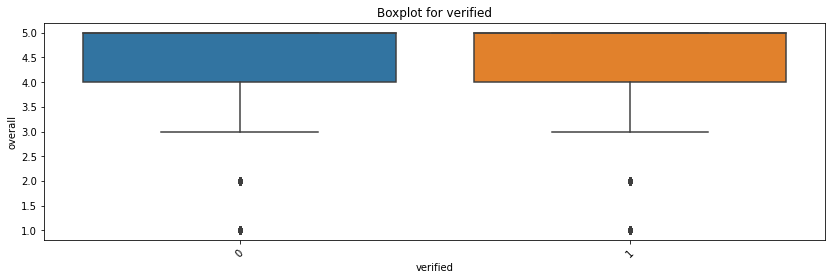

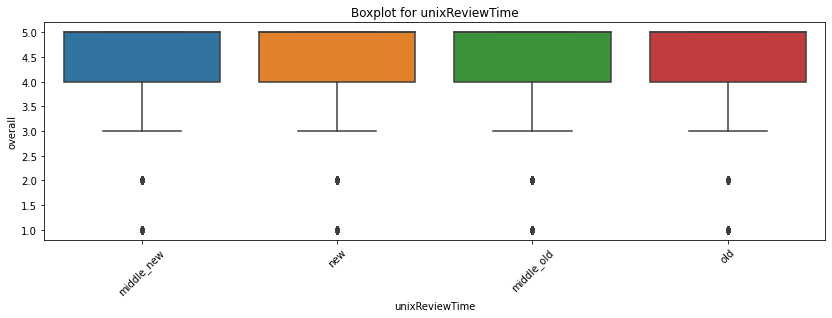

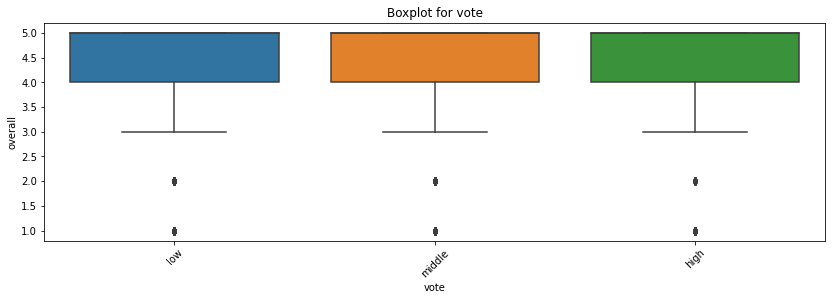

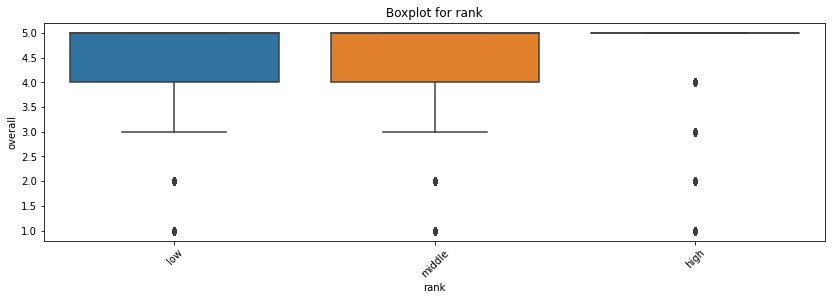

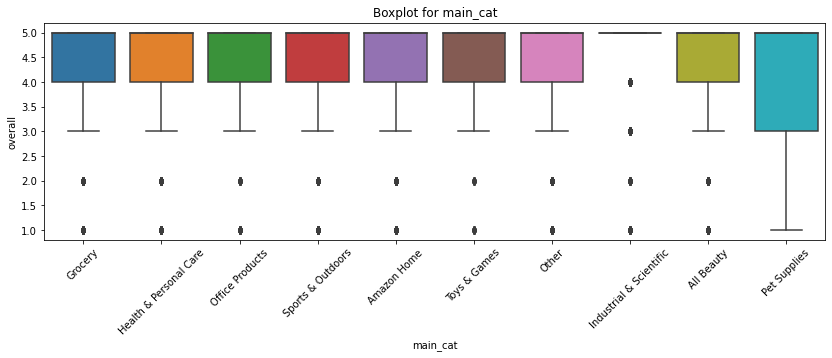

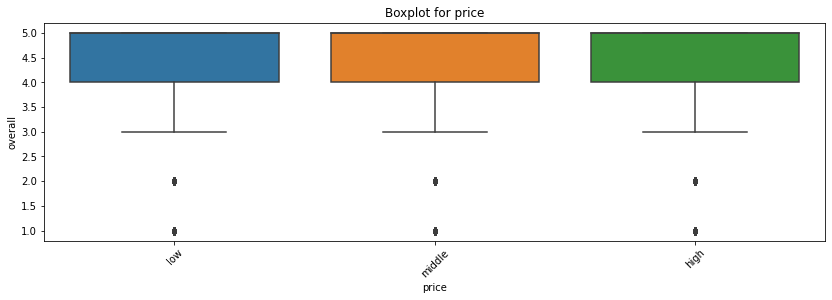

In [107]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_boxplot(col)

По графикам сильных различий не видно. Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий может помочь распознать статистика. Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок пользователей по различным параметрам неразличимы:

In [108]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'overall'], 
                        df.loc[df.loc[:, column] == comb[1], 'overall']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [109]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки unixReviewTime
Найдены статистически значимые различия для колонки vote
Найдены статистически значимые различия для колонки rank
Найдены статистически значимые различия для колонки main_cat
Найдены статистически значимые различия для колонки price


Убедились, что распредление оценок серьезно различается по всем шести параметрам.

Удалим признак overall

In [110]:
df = df.drop('overall', axis=1)

### Создадим dummy-переменные

In [111]:
#df.verified
#Для verified dummy-переменные не нужны т.к. там и так бинарные значения.

In [112]:
for column in ['unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    dummies = pd.get_dummies(df[column], prefix = df[column].name)
    # Удаляем исходный столбец и добавляем dummies
    df = df.drop(df[column].name, axis=1).join(dummies)

In [113]:
df.columns

Index(['verified', 'userid', 'itemid', 'rating', 'unixReviewTime_middle_new',
       'unixReviewTime_middle_old', 'unixReviewTime_new', 'unixReviewTime_old',
       'vote_high', 'vote_low', 'vote_middle', 'rank_high', 'rank_low',
       'rank_middle', 'main_cat_All Beauty', 'main_cat_Amazon Home',
       'main_cat_Arts, Crafts & Sewing', 'main_cat_Baby',
       'main_cat_Camera & Photo', 'main_cat_Cell Phones & Accessories',
       'main_cat_Grocery', 'main_cat_Health & Personal Care',
       'main_cat_Home Audio & Theater', 'main_cat_Industrial & Scientific',
       'main_cat_Musical Instruments', 'main_cat_Office Products',
       'main_cat_Other', 'main_cat_Pet Supplies', 'main_cat_Software',
       'main_cat_Sports & Outdoors', 'main_cat_Tools & Home Improvement',
       'main_cat_Toys & Games', 'price_high', 'price_low', 'price_middle'],
      dtype='object')

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 35 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   verified                            847593 non-null  int64  
 1   userid                              847593 non-null  int64  
 2   itemid                              847593 non-null  int64  
 3   rating                              847593 non-null  float64
 4   unixReviewTime_middle_new           847593 non-null  uint8  
 5   unixReviewTime_middle_old           847593 non-null  uint8  
 6   unixReviewTime_new                  847593 non-null  uint8  
 7   unixReviewTime_old                  847593 non-null  uint8  
 8   vote_high                           847593 non-null  uint8  
 9   vote_low                            847593 non-null  uint8  
 10  vote_middle                         847593 non-null  uint8  
 11  rank_high                 

### Итоги EDA

* overall - оценки от 1 до 5. Нет в тестовой выборке, использовали как вспомогательный признак для анализа.
* verified - привели значения к 0 и 1
* reviewTime - удалили признак т.к. есть unixReviewTime
* asin - удалили признак т.к. не использовали, хотя наверное могли бы для also_buy, also_view, similar_item
* reviewerName - удалили т.к. есть userid
* reviewText - выдилили самые часто встречающиеся слова. Но признака нет в тестовой выборке
* summary - удалили т.к. нет в тестовом датасете
* unixReviewTime - сделали 4 категории в зависимости от даты отзыва, сделали dummy-переменные
* vote - сделали 3 категории в зависимости от количества голосов, сделали dummy-переменные
* style - удалили т.к. больше половины пропусков
* image_x - удалили
* userid - оставили для модели
* itemid - оставили для модели
* rating - оставили для модели - целевая переменная
* category - выдилили самые часто встречающиеся категории, сделали (все подготовили и закомментировали для скорости) dummy-переменные
* description - выдилили самые часто встречающиеся слова, сделали (все подготовили и закомментировали для скорости) dummy-переменные
* title - удалили т.к. сильно похож на description
* brand - выдилили самых часто встречающихся производителей, сделали (все подготовили и закомментировали для скорости) dummy-переменные
* rank - сделали 3 категории в зависимости от ранга, сделали dummy-переменные
* also_view - удалили, но наверное можно было бы использовать
* main_cat - сделали dummy-переменные
* price - сделали 3 категории в зависимости от цены, сделали dummy-переменные
* also_buy - удалили, но наверное можно было бы использовать
* image_y - удалили
* date - удалили
* feature - удалили
* details - удалили
* similar_item - удалили, но наверное можно было бы использовать. Много пропусков.
* tech1 - удалили
* fit - удалили

### Предсказания без использования фичей

In [118]:
!pip install lightfm

     |████████████████████████████████| 317kB 14.8MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705340 sha256=dde683190a2af3be90ae34b8cad3b88f2083c3ce29c8f5bbaca56c45e41f1b1e
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [119]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

Делим тренировочный датасет на тренировочную и тестовую выборки

In [120]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

Чтобы работать с моделями в библиотеке LightFm, нам нужно создать разреженные матрицы. Мы будем хранить данные в формате COO (координатный формат представления данных). Вместо хранения всех значений, которые включают нулевые значения, мы будем хранить только ненулевые значения. В COO данные представлены в виде (строка, столбец, значение).

In [121]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'],)))

Обучаем модель

In [122]:
LR = 0.089
NUM_THREADS = 12 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

model = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model = model.fit(
    ratings_coo,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

Получим предсказания

In [123]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

Посчитаем метрику roc_auc_score

In [124]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7286978493109197

В качестве эксперимента создадим ещё одну модель, тренировочным датасетом для которой пойдет преобразованный исходный train.csv с созданными нами фичами

In [132]:
train_data, test_data = train_test_split(df,random_state=32, shuffle=True)

In [133]:
# Создадим разреженную матрицу
ratings_coo2 = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'],)))

# Обучим модель
model2 = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model2 = model.fit(
    ratings_coo2,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

In [134]:
preds2 = model2.predict(test_data.userid.values,
                      test_data.itemid.values)

In [135]:
sklearn.metrics.roc_auc_score(test_data.rating,preds2)

0.7413949196310475

А теперь обучим на исходном train и нашем df и построим предсказания на тестовом датасете test

In [136]:
# Создадим разреженную матрицу
ratings_coo3 = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'],)))

# Обучим модель
model3 = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model3 = model.fit(
    ratings_coo3,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

In [137]:
preds3 = model3.predict(test.userid.values,
                      test.itemid.values)

In [139]:
# Создадим разреженную матрицу
ratings_coo4 = sparse.coo_matrix((df['rating'].astype(int),
                                 (df['userid'],
                                  df['itemid'],)))

# Обучим модель
model4 = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model4 = model.fit(
    ratings_coo4,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

In [140]:
preds4 = model4.predict(test.userid.values,
                      test.itemid.values)

Нормализуем предсказания

In [142]:
#Предсказание на тестовом датасете, предварительно обучив модель на всем train
normalized_preds = (preds3 - preds3.min())/(preds3 - preds3.min()).max()
#Предсказание на тестовом датасете, предварительно обучив модель на df
normalized_preds4 = (preds4 - preds4.min())/(preds4 - preds4.min()).max()

### Submission

In [143]:
submission['rating']= normalized_preds
submission.to_csv('submission_train.csv', index=False)

In [145]:
submission['rating']= normalized_preds4
submission.to_csv('submission_df.csv', index=False)